In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import load_datacube as load
import obs_tools as obs
import cov_tools as cov

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Line-of-sight  analysis of frequency covariance

In this notebook we show how to calculate the frequency covariance, and then analyse some line of sight samples from it, in order to see how the covariance is evolving with frequency (redshift).

Start by loading in the 21cm, unpolarised foreground, polarised foreground and noise data and smoothing by the telescope beam.

In [3]:
# loading 21cm, smooth fg and polarised fg data:
HI_data = np.load('../Data/T_HI-MDSAGE_z_0.39.npy')
HI_data = np.swapaxes(HI_data, 1, 2)
FGnopol_data = (np.load('../Data/dT_sync_Stripe82_noBeam.npy')
               +np.load('../Data/dT_free_Stripe82_noBeam.npy')
               +np.load('../Data/dT_psource_Stripe82_noBeam.npy'))
FGpol_data = np.load('../Data/dT_pleak_Stripe82_noBeam.npy')
noise_data = np.load('../Data/dT_noise.npy')

# smoothing by the telescope beam:
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
zmax = 0.58
sigma_beam = 1.55
HI_data_smoothed = obs.ConvolveCube(HI_data,zmax,lx,ly, sigma_beam, cosmo)
FGnopol_data_smoothed = obs.ConvolveCube(FGnopol_data,zmax,lx,ly, sigma_beam, cosmo)
FGpol_data_smoothed = obs.ConvolveCube(FGpol_data,zmax,lx,ly, sigma_beam, cosmo)
noise_data_smoothed = obs.ConvolveCube(noise_data,zmax,lx,ly, sigma_beam, cosmo)

Calculate frequency covariance matrices:

In [5]:
# image data:
C_HI = np.cov(load.LoSpixels(HI_data_smoothed))
C_FGnopol = np.cov(load.LoSpixels(FGnopol_data_smoothed)[::-1])
C_FGpol = np.cov(load.LoSpixels(FGpol_data_smoothed)[::-1])
C_noise = np.cov(load.LoSpixels(noise_data_smoothed))

Define frequency range of the data:

In [6]:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
freqs = np.arange(vmin, vmax, df)

## HI Data

In [7]:
kernel_name='Exponential'
# get Z (samples from multivariate distribution with mean zero and covariance C) and C (covariance):
Z, C = cov.get_kernel_samples(kernel_name, freqs, 20, l=2)

Text(0.5, 1.0, 'HI data covariance')

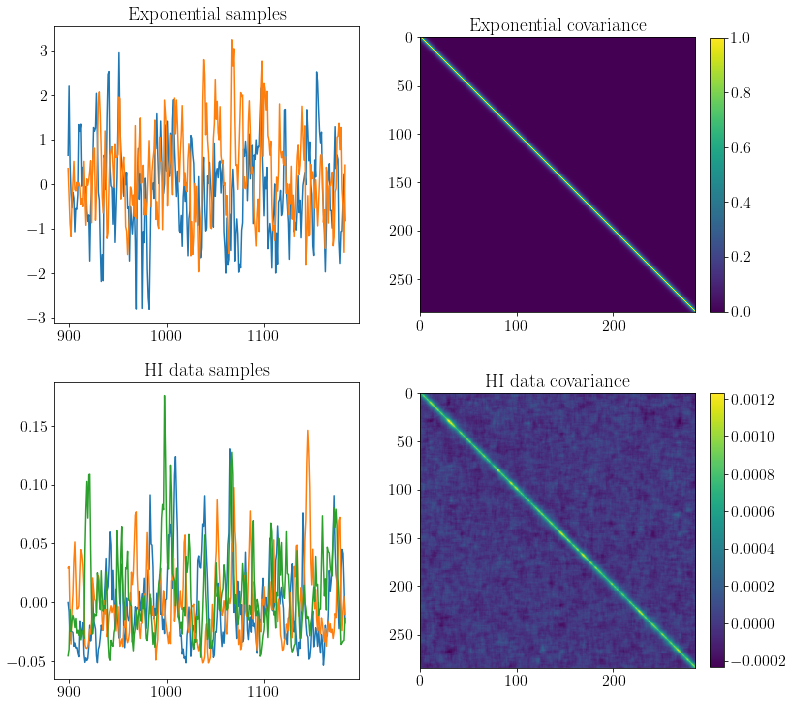

In [8]:
fig = plt.figure(figsize=(12,12))     # open a new plotting window
plt.subplot(221)
for i in range(2):
    plt.plot(freqs,Z[i,:])
plt.title('{} samples'.format(kernel_name))

plt.subplot(222)
pos = plt.imshow(C, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name))

plt.subplot(223)
for i in (11,110,210):
    plt.plot(freqs, load.LoSpixels(HI_data)[:,i])
plt.title('HI data samples')

plt.subplot(224)
pos = plt.imshow(np.real(C_HI), interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('HI data covariance')

## Noise

In [9]:
kernel_name='Exponential'
Z, C = cov.get_kernel_samples(kernel_name, freqs, 20, l=0.1)

Text(0.5, 1.0, 'Noise data covariance')

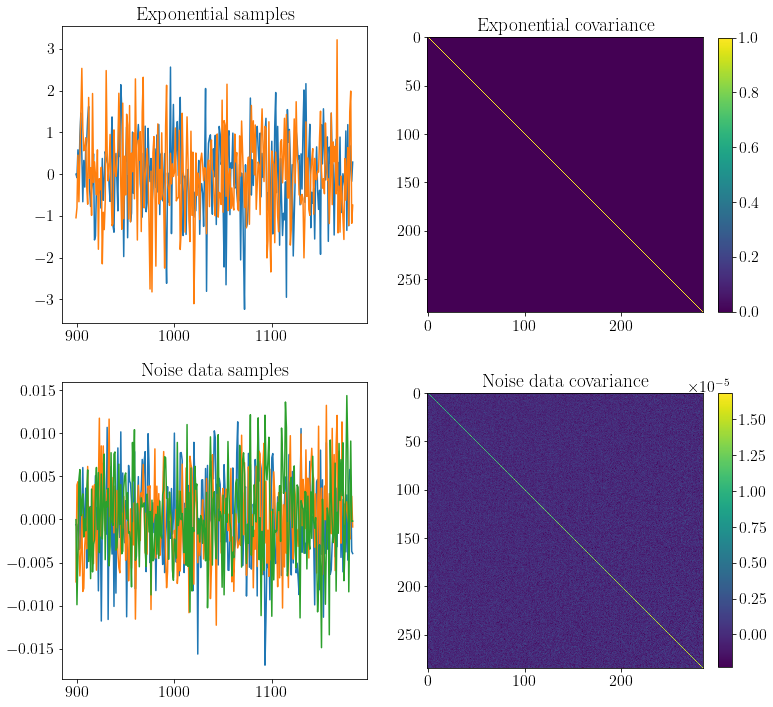

In [10]:
fig = plt.figure(figsize=(12,12))     # open a new plotting window
plt.subplot(221)
for i in range(2):
    plt.plot(freqs,Z[i,:])
plt.title('{} samples'.format(kernel_name))

plt.subplot(222)
pos = plt.imshow(C, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name))

plt.subplot(223)
for i in (11,110,210):
    plt.plot(freqs, load.LoSpixels(noise_data_smoothed)[:,i])
plt.title('Noise data samples')

plt.subplot(224)
pos = plt.imshow(np.real(C_noise), interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('Noise data covariance')

## FG data (no polarisation)

In [11]:
kernel_name_poly='Poly'
Z_poly, C_poly = cov.get_kernel_samples(kernel_name_poly, freqs, 20)
kernel_name_rbf='RBF'
Z_rbf, C_rbf = cov.get_kernel_samples(kernel_name_rbf, freqs, 20, l=500)

Text(0.5, 1.0, 'FG data (no pol) covariance')

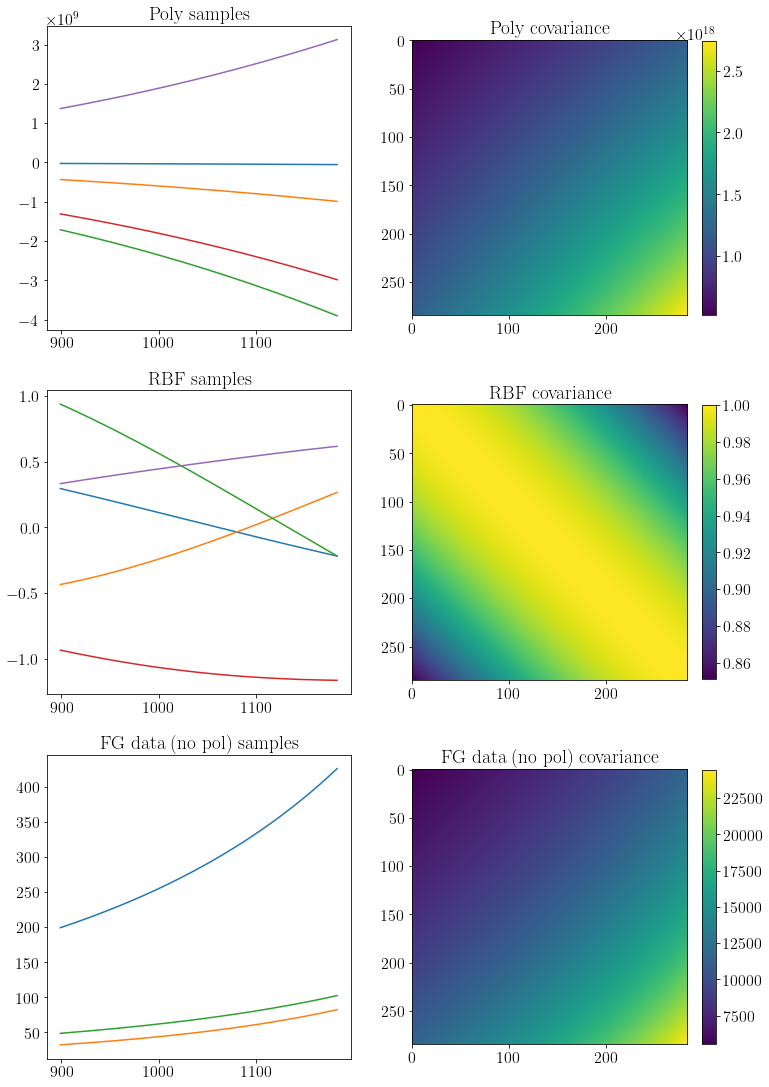

In [12]:
fig = plt.figure(figsize=(12,19))

plt.subplot(321)
for i in range(5):
    plt.plot(freqs, Z_poly[i,:])
plt.title('{} samples'.format(kernel_name_poly))

plt.subplot(322)
pos = plt.imshow(C_poly, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name_poly))

plt.subplot(323)
for i in range(5):
    plt.plot(freqs, Z_rbf[i,:])
plt.title('{} samples'.format(kernel_name_rbf))

plt.subplot(324)
pos = plt.imshow(C_rbf, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name_rbf))

plt.subplot(325)
for i in (11, 100, 200):
    plt.plot(freqs, load.LoSpixels(FGnopol_data_smoothed)[:,i][::-1])
plt.title('FG data (no pol) samples')

plt.subplot(326)
pos = plt.imshow(np.real(C_FGnopol), interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('FG data (no pol) covariance')

## FG data (with polarisation)

In [13]:
kernel_name='RatQuad'
# get Z (samples from multivariate distribution with mean zero and covariance C) and C (covariance):
Z, C = cov.get_kernel_samples(kernel_name, freqs, 20, l=200)

Text(0.5, 1.0, 'FG data (w pol) covariance')

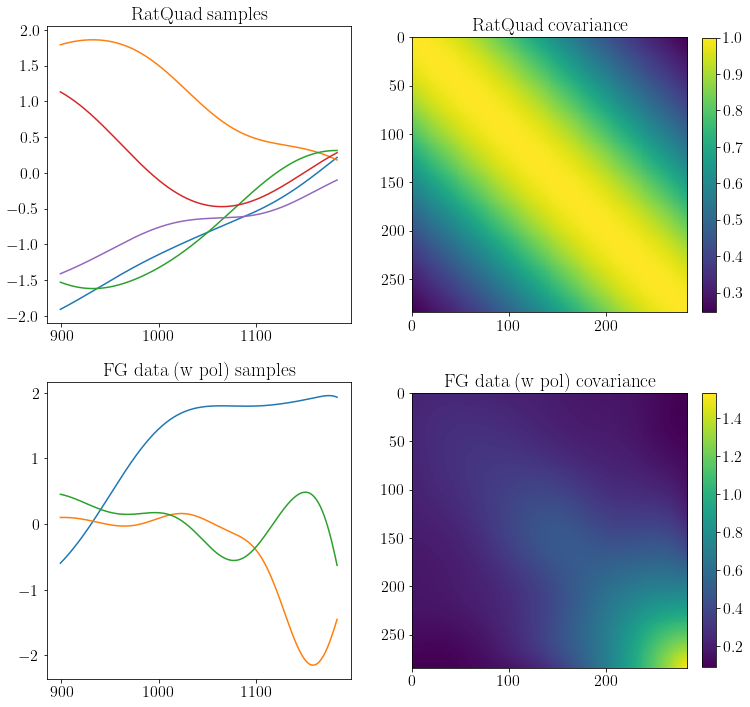

In [14]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
for i in range(5):
    plt.plot(freqs,Z[i,:])
plt.title('{} samples'.format(kernel_name))

plt.subplot(222)
pos = plt.imshow(C, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name))

plt.subplot(223)
for i in (11, 100, 200):
    plt.plot(freqs, load.LoSpixels(FGpol_data_smoothed)[:,i][::-1])
plt.title('FG data (w pol) samples')

plt.subplot(224)
pos = plt.imshow(np.real(C_FGpol), interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('FG data (w pol) covariance')